### **gmv_models**

Run hierarchical models on project data:
- Test hypothesis (d), that age-related differences in aperiodic activity are modulated by regional gray matter volume.

Author: EL Johnson, PhD

Copyright (c) 2022-2025  
ZR Cross, PhD & EL Johnson, PhD

### Set directories:

In [449]:
pth <- getwd() # navigate to directory containing folders of downloaded data
datdir_gmv <- paste(getwd(), 'volume_stats', sep = '/')
datdir_demo <- paste(pth, 'Preprocessed_data', sep = '/')
savdir <- datdir_demo # replace with your save path

### Load packages:  
If lme4 needs to be installed, run on the Anaconda command line:  
conda install -c conda-forge r-lme4

In [450]:
library(tidyverse)
library(RColorBrewer)
library(broom)
library(lme4)
library(splines)

### Build outlier detection function:

In [451]:
outlierKD <- function(dt, var) {
    var_name <- eval(substitute(var),eval(dt))
    tot <- sum(!is.na(var_name))
    na1 <- sum(is.na(var_name))
    m1 <- mean(var_name, na.rm = T)
    par(mfrow=c(2, 2), oma=c(0,0,3,0))
    boxplot(var_name, main='With outliers')
    hist(var_name, main='With outliers', xlab=NA, ylab=NA)
    outlier <- boxplot.stats(var_name)$out
    mo <- mean(outlier)
    var_name <- ifelse(var_name %in% outlier, NA, var_name)
    boxplot(var_name, main='Without outliers')
    hist(var_name, main='Without outliers', xlab=NA, ylab=NA)
    title('Outlier check', outer=TRUE)
    na2 <- sum(is.na(var_name))
    message('Outliers identified: ', na2 - na1, ' from ', tot, ' observations')
    message('Proportion (%) of outliers: ', (na2 - na1) / tot*100)
    message('Mean of the outliers: ', mo)
    m2 <- mean(var_name, na.rm = T)
    message('Mean without removing outliers: ', m1)
    message('Mean if we remove outliers: ', m2)
    response <- readline(prompt='Do you want to remove outliers and to replace with NA? [yes/no]: ')
  
    if(response == 'y' | response == 'yes'){
        dt[as.character(substitute(var))] <- invisible(var_name)
        assign(as.character(as.list(match.call())$dt), dt, envir = .GlobalEnv)
        message('Outliers successfully removed', '\n')
        return(invisible(dt))
    } else{
        message('Nothing changed', '\n')
        return(invisible(var_name))
    }
}

remove_outliers_tukey <- function(x) {
    qnt <- quantile(x, probs=c(.25, .75), na.rm = TRUE)
    H <- 1.5 * IQR(x, na.rm = TRUE)
    outliers <- sum(x < (qnt[1] - H) | x > (qnt[2] + H), na.rm = TRUE)
    x[x < (qnt[1] - H)] <- NA
    x[x > (qnt[2] + H)] <- NA
    return(list(data = x, outliers = outliers))
}

### Load GMV estimates:

In [452]:
# function to read freesurfer stats files
read_fs_stats <- function(filepath) {
      lines <- readLines(filepath)
      
      # find the data section (lines that don't start with #)
      data_lines <- lines[!grepl('^#', lines)]
      
      # remove empty lines
      data_lines <- data_lines[data_lines != '']
      
      # parse into data frame
      if(length(data_lines) > 0) {
            df <- read.table(text = paste(data_lines, collapse = '\n'),
                             header = FALSE, 
                             stringsAsFactors = FALSE,
                             col.names = c('StructName', 'NumVert', 'SurfArea', 'GrayVol', 
                                           'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 
                                           'FoldInd', 'CurvInd'))
          return(df)
          }
    return(data.frame())
}

# read files
stats_files <- list.files(datdir_gmv, pattern = 'aparc.DKTatlas.stats$', full.names = TRUE, recursive = TRUE)
dat_list <- lapply(stats_files, read_fs_stats)

# combine with subject IDs extracted from filename
dat <- do.call(rbind, lapply(seq_along(dat_list), function(i) {
    df <- dat_list[[i]]
    fid <- basename(stats_files[i])
    df$subj <- sub('_.*', '', fid)
    return(df)
}))

### Combine into DKT regions:

In [453]:
# average over ROIs
average_gray_vol <- dat %>% 
    select(subj, GrayVol, StructName, ThickAvg) %>%
    group_by(subj, StructName) %>%
    dplyr::summarise(gmv = mean(GrayVol), thick = mean(ThickAvg))
ggseg_roi <- as.data.frame(unique(average_gray_vol$StructName))

# reStructName StructName to DKT
filtered_df <- average_gray_vol %>% 
      rename(DKT = StructName)

In [454]:
# specify the levels of DKT to duplicate and their corresponding new StructNames
levels_to_duplicate <- c('cuneus',                   # 2
                         'entorhinal',               # 3
                         'isthmuscingulate',         # 4
                         'lingual',                  # 5
                         'paracentral',              # 6
                         'parsopercularis',          # 7
                         'parsorbitalis',            # 8
                         'parstriangularis',         # 9
                         'pericalcarine',            # 10
                         'precuneus',                # 11
                         'rostralanteriorcingulate', # 12
                         'superiorfrontal',          # 13
                         'supramarginal',            # 14
                         'transversetemporal',       # 15
                         'caudalanteriorcingulate',  # 16
                         'caudalmiddlefrontal',      # 17
                         'fusiform',                 # 18
                         'inferiorparietal',         # 19
                         'inferiortemporal',         # 20
                         'insula',                   # 21
                         'lateraloccipital',         # 22
                         'lateralorbitofrontal',     # 23
                         'medialorbitofrontal',      # 24
                         'middletemporal',           # 25
                         'parahippocampal',          # 26
                         'postcentral',              # 27
                         'posteriorcingulate',       # 28
                         'precentral',               # 29
                         'rostralmiddlefrontal',     # 30
                         'superiorparietal',         # 31
                         'superiortemporal',         # 32
                         'temporalpole'              # 33
                         )                         

new_StructNames <- c('lateral occipital',                 # 2
                'parahippocampal',                   # 3
                'posterior cingulate',               # 4
                'lateral occipital',                 # 5
                'precentral',                        # 6
                'inferior frontal',                  # 7
                'inferior frontal',                  # 8
                'inferior frontal',                  # 9
                'lateral occipital',                 # 10
                'superior parietal',                 # 11
                'caudal anterior cingulate',         # 12
                'caudal middle frontal',             # 13
                'superior parietal',                 # 14
                'superior temporal' ,                # 15
                'caudal anterior cingulate',         # 16
                'caudal middle frontal',             # 17
                'fusiform',                          # 18
                'inferior parietal',                 # 19
                'inferior temporal',                 # 20
                'insula',                            # 21
                'lateral occipital',                 # 22
                'lateral orbitofrontal',             # 23
                'medial orbitofrontal',              # 24
                'middle temporal',                   # 25
                'parahippocampal',                   # 26
                'postcentral',                       # 27
                'posterior cingulate',               # 28
                'precentral',                        # 29
                'rostral middle frontal',            # 30
                'superior parietal',                 # 31
                'superior temporal',                 # 32
                'superior temporal'                  # 33
                )

In [455]:
# create a data frame with levels to duplicate and their corresponding new StructNames
df_StructNames <- tibble(DKT = levels_to_duplicate, new_StructName = new_StructNames)

# duplicate the entire data frame
df_duplicated_dkt <- bind_rows(replicate(3, filtered_df, simplify = FALSE))

# filter rows that need duplication, adjust DKT column and other columns accordingly
df_duplicated_dkt <- df_duplicated_dkt %>%
    mutate(duplicate = row_number()) %>%
    left_join(df_StructNames, by = 'DKT') %>%
    mutate(DKT = ifelse(!is.na(new_StructName), new_StructName, DKT)) %>%
    select(-new_StructName) %>%
    filter(!is.na(duplicate)) %>%
    group_by(duplicate) %>%
    slice(rep(1:n(), each = 3)) %>%
    ungroup() %>%
    select(-duplicate)

In [456]:
# calculate the mean of values for each group of duplicated rows
df_means <- df_duplicated_dkt %>%
    group_by(DKT, subj) %>%
    summarise(gmv = mean(gmv, na.rm = TRUE)) %>%
    ungroup()

### Join with the aperiodic slope data:

In [457]:
dat_load <- paste(datdir_demo, 'aperiodic_slope_models.csv', sep = '/')
df <- read.csv(dat_load, header = T) %>%
    select(subj, realID, DKT, brodmann, sex, Slope, Offset, age, R.2, task) %>%
    group_by(subj, realID, DKT, brodmann, sex, task) %>% 
    filter(R.2 >= .90) %>% 
    summarise_all(list(mean), na.rm = FALSE)

### Remove slope outliers:

Outliers identified: 11 from 6911 observations
Proportion (%) of outliers: 0.15916654608595
Mean of the outliers: 1.04319787180624
Mean without removing outliers: 2.12290870946178
Mean if we remove outliers: 2.12462998760877


Do you want to remove outliers and to replace with NA? [yes/no]:  yes


Outliers successfully removed



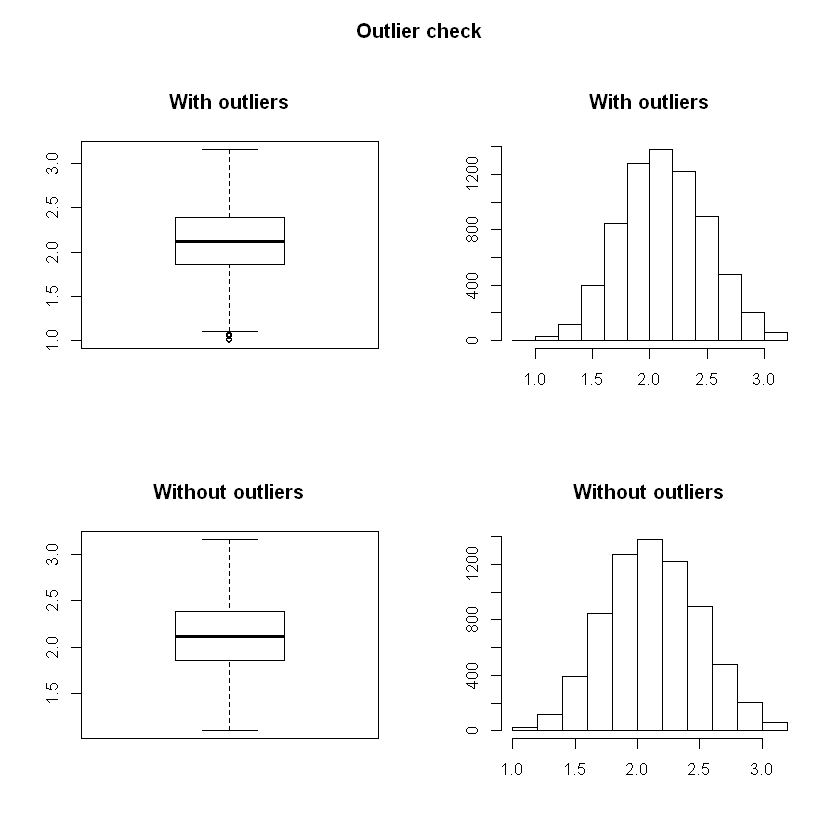

In [458]:
average_df <- df %>%
      dplyr::group_by(DKT) %>%
      dplyr::mutate(
          Slope_no_outliers = remove_outliers_tukey(Slope)$data,
          ) %>%
ungroup()

# overwrite original aperiodic columns with the outliers removed
average_df$Slope <- average_df$Slope_no_outliers
outlierKD(average_df, Slope)

### Final data frame:

In [459]:
full_data <- left_join(average_df, df_means, by = c('subj', 'DKT')) %>%
      filter(DKT != 'Other') %>%
      select(subj, realID, Slope, Offset, gmv, age, task, DKT, sex) %>%
      ungroup() %>%
      group_by(subj, realID, task, DKT, sex) %>%
      summarise_all(funs(mean), na.rm = FALSE)

### Fix parahippocampal data:

In [460]:
# group by 'subj' and 'DKT', and find the unique 'parahippocampal' gmv value for each 'subj'
parahippocampal_gmv <- full_data %>%
      dplyr::select(subj, DKT, gmv) %>% 
      dplyr::filter(DKT == 'parahippocampal') %>%
      dplyr::group_by(subj) %>%
      summarize(parahippocampal_gmv = unique(gmv))

# merge the parahippocampal gmv values with the original data frame
full_data <- full_data %>%
      left_join(parahippocampal_gmv, by = 'subj') %>%
      mutate(gmv = ifelse(DKT %in% c('hippocampus', 'amygdala'), parahippocampal_gmv, gmv)) %>%
      select(-parahippocampal_gmv)  # remove the auxiliary column

# ensure gmv values are not overwritten for parahippocampal
full_data$gmv[full_data$DKT == 'parahippocampal'] <- full_data$gmv[full_data$DKT == 'parahippocampal']  # just to be explicit

Adding missing grouping variables: `realID`, `task`


### Factorize variables:

In [461]:
full_data$subj <- as.factor(full_data$subj)
full_data$realID <- as.factor(full_data$realID)
full_data$DKT <- as.factor(full_data$DKT)
full_data$task <- as.factor(full_data$task)
full_data$sex <- as.factor(full_data$sex)

### Remove GMV outliers:

In [462]:
# run this for generating the plots at the end of the script
full_data2 <- full_data2 %>%
      dplyr::group_by(DKT) %>%
      dplyr::mutate(
        gmv_no_outliers = remove_outliers_tukey(gmv)$data,
        gmv_outliers_removed = remove_outliers_tukey(gmv)$outliers
          ) %>%
ungroup()

# overwrite original aperiodic columns with the outliers removed
full_data2$gmv <- full_data2$gmv

# run this for formal statistics
full_data <- full_data %>% 
  filter(DKT != 'subcortical' & task != 'Rest')

### Plot GMV by age:

In [463]:
# join age data to gmv information
age_data <- average_df %>%
    select(subj, age) %>% 
      group_by(subj) %>% 
      summarise(age = mean(age))
gray_data <- left_join(average_gray_vol, age_data, by = 'subj')

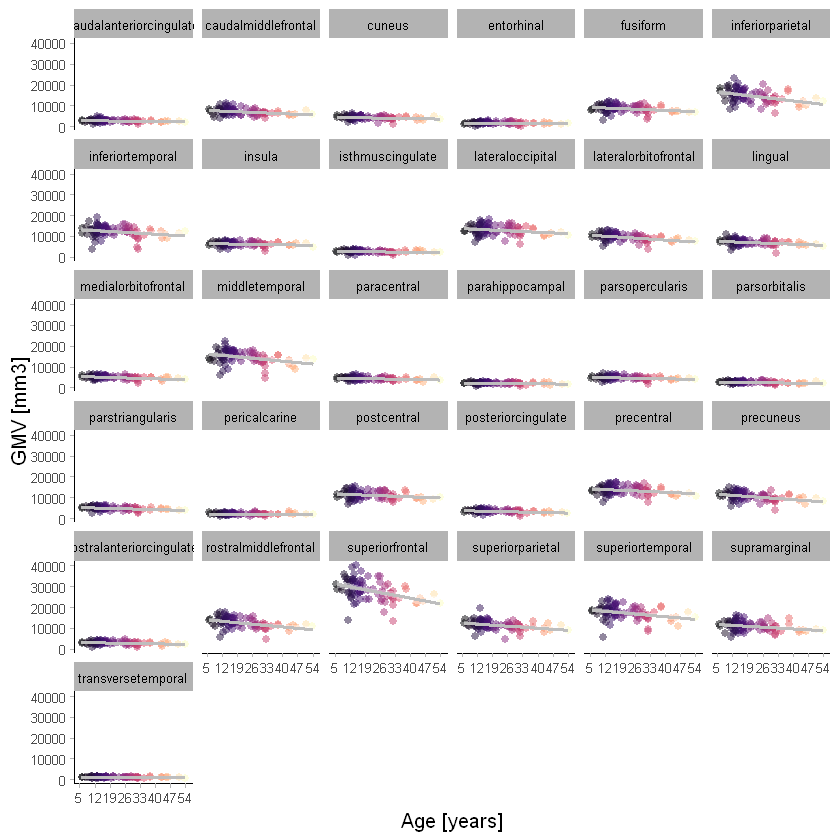

In [464]:
ggplot(gray_data %>% filter(StructName != 'temporalpole'), aes(x = age, y = gmv, color = age)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, alpha = 0.5, position = position_jitter(width = 0.2)) + 
    xlab('Age [years]') + ylab ('GMV [mm3]') +
      theme_light() +
      facet_wrap(~StructName) +
      geom_smooth(method = 'lm', linetype = 'solid', colour = 'gray', fill = 'NA') +
      scale_color_viridis_c(option = 'magma') +
      scale_x_continuous(limits = c(5, 55), breaks = seq(5, 55, by = 7)) +
      scale_y_continuous(breaks = scales::pretty_breaks(n = 5)) +
      theme(legend.position='none',
            legend.spacing.x = unit(0.2, 'cm'),
            legend.key.size = unit(0.4, 'cm'),
            legend.background = element_rect(fill=alpha('blue', 0)),
            legend.text = element_text(size = 8, colour = 'black'),
            legend.title = element_text(size = 8, colour = 'black', face = 'bold'), 
            strip.text.x = element_text(size = 8, colour = 'black'),
            strip.text.y = element_text(size = 8, colour = 'black'),
            axis.text = element_text(size = 8),
            axis.title = element_text(size = 12),
            plot.title = element_text(size = 8, face = 'bold'),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(color = 'black'),
            axis.line.y.right = element_blank(),
            axis.line.x.top = element_blank())

### Add additional age data for analysis of total GMV:

In [465]:
dat_load = paste(datdir_demo, 'additional_ages.csv', sep = '/')
additional_ages <- read.csv(dat_load)
colnames(additional_ages)[1] <- 'subj'

# summarise across all regions
average_gmv_scatter <- gray_data %>%
    dplyr::select(subj, gmv, age, thick) %>% 
    dplyr::ungroup() %>% 
    dplyr::group_by(subj) %>% 
    dplyr::summarise_all(funs(mean), na.rm = FALSE)

average_gmv_scatter <- average_gmv_scatter %>%
    left_join(additional_ages, by = 'subj') %>%
    mutate(age = coalesce(age.x, age.y)) %>%
    select(-age.x, -age.y)

### Remove outliers from total GMV:

Outliers identified: 2 from 83 observations
Proportion (%) of outliers: 2.40963855421687
Mean of the outliers: 3826.53225806452
Mean without removing outliers: 8082.41296638166
Mean if we remove outliers: 8187.49644066109


Do you want to remove outliers and to replace with NA? [yes/no]:  yes


Outliers successfully removed



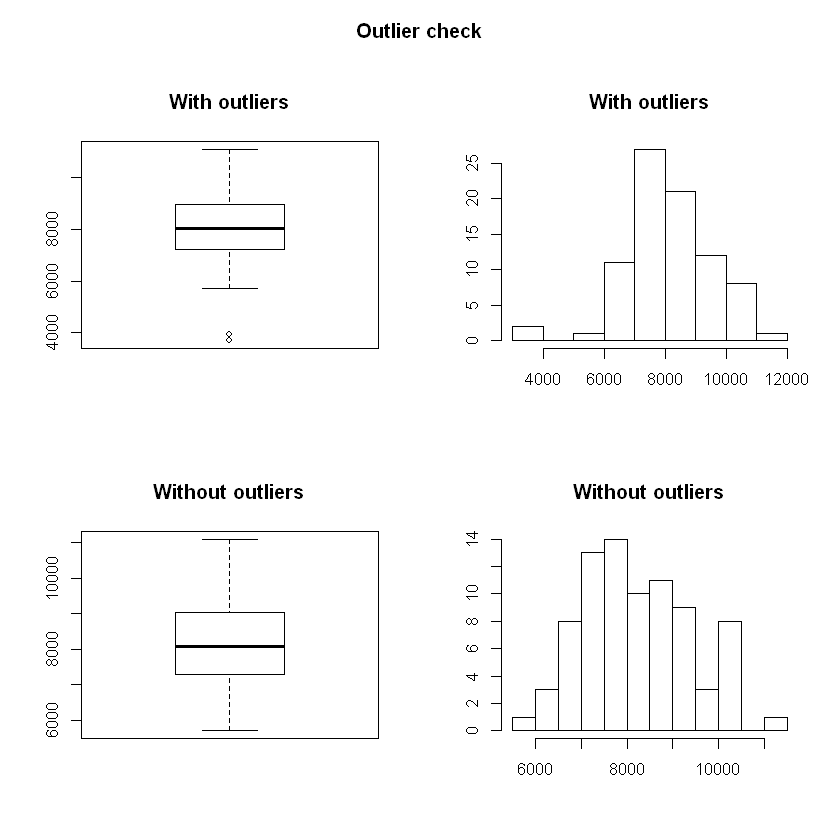

In [466]:
outlierKD(average_gmv_scatter, gmv)

### Plot total GMV by age:

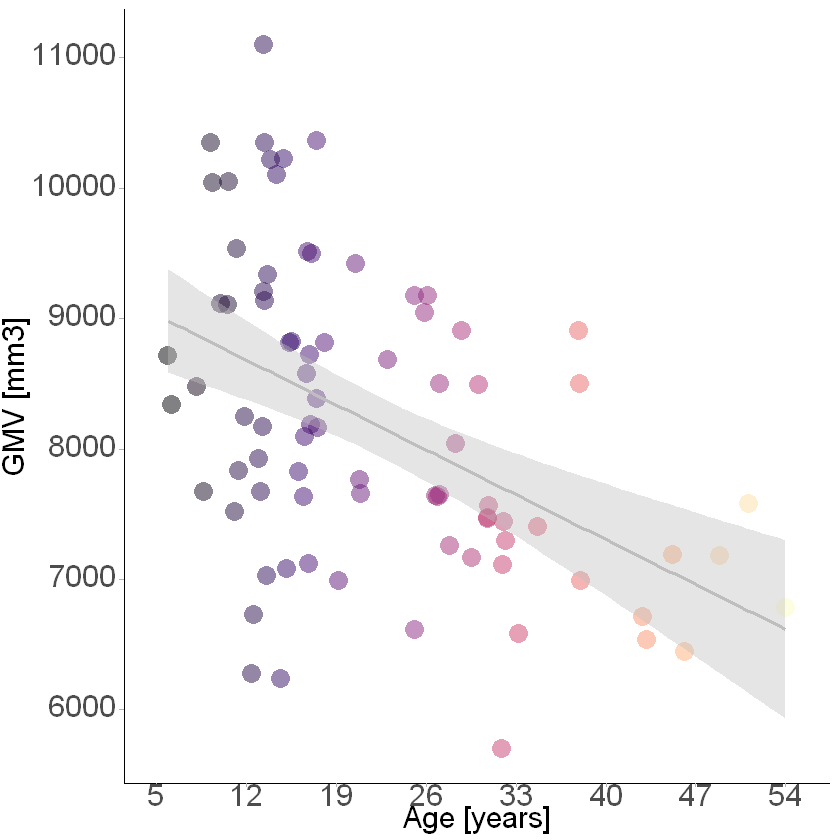

In [467]:
ggplot(average_gmv_scatter, aes(x = age, y = gmv, color = age)) + 
    geom_point(shape = 16, size = 5, show.legend = FALSE, alpha = 0.5, position = position_jitter(width = 0.2)) +
      xlab('Age [years]') + ylab ('GMV [mm3]') +
      theme_light() +
      geom_smooth(method = 'lm', linetype = 'solid', colour = 'gray', fill = 'gray') +
      scale_color_viridis_c(option = 'magma') +
      scale_x_continuous(limits = c(5, 55), breaks = seq(5, 55, by = 7)) +
      scale_y_continuous(breaks = scales::pretty_breaks(n = 7)) +
      theme(legend.position='none',
            legend.spacing.x = unit(0.2, 'cm'),
            legend.key.size = unit(0.4, 'cm'),
            legend.background = element_rect(fill=alpha('blue', 0)),
            legend.text = element_text(size = 16, colour = 'black'),
            legend.title = element_text(size = 16, colour = 'black', face = 'bold'), 
            strip.text.x = element_text(size = 18, colour = 'black'),
            strip.text.y = element_text(size = 18, colour = 'black'),
            axis.text = element_text(size = 18),
            axis.title = element_text(size = 18),
            plot.title = element_text(size = 16, face = 'bold'),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(color = 'black'),
            axis.line.y.right = element_blank(),
            axis.line.x.top = element_blank())

### Run linear regression for GMV by age:

In [468]:
gmv_lm <- lm(gmv ~ age, data = average_gmv_scatter)
summary(gmv_lm)


Call:
lm(formula = gmv ~ age, data = average_gmv_scatter)

Residuals:
    Min      1Q  Median      3Q     Max 
-2384.8  -620.6  -239.3   741.6  2478.5 

Coefficients:
            Estimate Std. Error t value             Pr(>|t|)    
(Intercept)  9272.30     251.24  36.905 < 0.0000000000000002 ***
age           -49.20      10.15  -4.849            0.0000061 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1029 on 79 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2294,	Adjusted R-squared:  0.2196 
F-statistic: 23.51 on 1 and 79 DF,  p-value: 0.000006101


### Save total GMV model:

In [469]:
dat_save <- paste(savdir, 'total_gmv_age.RData', sep = '/')
save(gmv_lm, file = dat_save)

### Test hypothesis (d):

In [470]:
# function to loop through DKT regions
run_lmm_and_extract_effects <- function(data) {
    data <- na.omit(data)
    model <- lmer(Slope ~ age * gmv + (1 | subj/realID) + (1|task), data = data, control = lmerControl(optimizer = 'bobyqa'))
    
    # Create prediction grid
    age_range <- seq(min(data$age), max(data$age), length.out = 20)
    gmv_range <- seq(min(data$gmv), max(data$gmv), length.out = 20)
    pred_grid <- expand.grid(age = age_range, gmv = gmv_range)
    
    # Get predictions
    pred_grid$predicted <- predict(model, newdata = pred_grid, re.form = NA)
    
    # Simple confidence intervals using model standard errors
    mm <- model.matrix(~ age * gmv, data = pred_grid)
    pvar <- diag(mm %*% tcrossprod(vcov(model), mm))
    pred_grid$conf.low <- pred_grid$predicted - 1.39 * sqrt(pvar)  # ~83% CI
    pred_grid$conf.high <- pred_grid$predicted + 1.39 * sqrt(pvar)
    
    return(pred_grid)
}

# create an empty list to populate with DKT labels
DKT_levels <- unique(full_data$DKT)
combined_results <- data.frame()
results_df_slope <- data.frame()

In [471]:
# apply lmer function in loop through DKT regions
for (level in DKT_levels) {
    cat('Processing DKT level:', level, '...\n')
      
    # subset the data
    subset_data <- full_data[full_data$DKT == level, ]

    # run lmer and extract effects
    results <- run_lmm_and_extract_effects(subset_data)
    
    # add the DKT level as a column in the results
    results$DKT <- level

    # append results to combined_results
    combined_results <- rbind(combined_results, results)
    
    # run lmer for slope results
    model <- lmer(Slope ~ age * gmv + (1 | subj/realID) + (1|task), data = subset_data, control = lmerControl(optimizer = 'bobyqa'))
    summary_model <- summary(model)
    
    # extract estimates, standard errors, and p-values for the fixed effects
    fixed_effects <- summary_model$coefficients[c(2, 3, 4), ]
  
    # create a new data frame to store the results for slope
    result_row <- data.frame(
        DKT = level,
        Estimate_Age = fixed_effects[1, 'Estimate'],
        SE_Age = fixed_effects[1, 'Std. Error'],
        PValue_Age = fixed_effects[1, 'Pr(>|t|)'],
        Estimate_GMV = fixed_effects[2, 'Estimate'],
        SE_GMV = fixed_effects[2, 'Std. Error'],
        PValue_GMV = fixed_effects[2, 'Pr(>|t|)'],
        Estimate_Interaction = fixed_effects[3, 'Estimate'],
        SE_Interaction = fixed_effects[3, 'Std. Error'],
        PValue_Interaction = fixed_effects[3, 'Pr(>|t|)']
    )

    # append the results to the main data frame for slope
    results_df_slope <- rbind(results_df_slope, result_row)
}

Processing DKT level: inferior parietal ...
Processing DKT level: postcentral ...
Processing DKT level: lateral occipital ...
Processing DKT level: superior temporal ...
Processing DKT level: fusiform ...
Processing DKT level: middle temporal ...
Processing DKT level: caudal middle frontal ...
Processing DKT level: inferior temporal ...
Processing DKT level: parahippocampal ...
Processing DKT level: caudal anterior cingulate ...
Processing DKT level: rostral middle frontal ...
Processing DKT level: posterior cingulate ...
Processing DKT level: superior parietal ...
Processing DKT level: precentral ...
Processing DKT level: medial orbitofrontal ...
Processing DKT level: inferior frontal ...
Processing DKT level: lateral orbitofrontal ...
Processing DKT level: hippocampus ...
Processing DKT level: insula ...
Processing DKT level: amygdala ...


In [472]:
# combine the results into a single data frame
combined_results <- combined_results %>% 
    rename(Slope = predicted)

# generate table of all results for aperiodic slope
slope_table <- results_df_slope %>% 
    dplyr::rename(ROI = DKT, P_Age = PValue_Age, P_GMV = PValue_GMV, P_Interaction = PValue_Interaction)

### Save model results:

In [475]:
dat_save <- paste(savdir, 'results_slope_gmv.csv', sep = '/')
write.csv(slope_table, dat_save, row.names = FALSE)

### Plot GMV*age interaction in posterior cingulate:

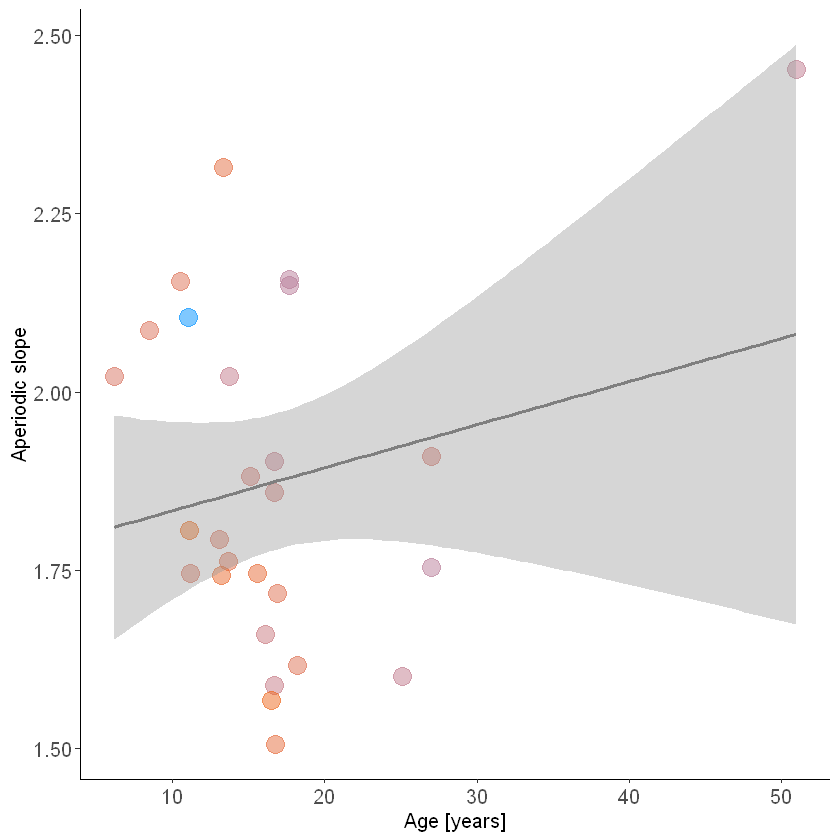

In [477]:
plot_data_pcc <- full_data %>% 
    ungroup() %>% 
    select(subj, DKT, Slope, age, gmv, task, Offset, sex) %>% 
    filter(DKT == 'posterior cingulate' | DKT == 'postcentral') %>% 
    group_by(subj, DKT, task, sex) %>% 
    summarise_all(funs(mean), na.rm = FALSE)

ggplot(filter(na.omit(plot_data_pcc), DKT == 'posterior cingulate'), aes(x = age, y = Slope, color = gmv)) + 
    geom_point(alpha = .5, size = 5) +
    geom_smooth(method = 'lm', linetype = 'solid', colour = 'gray50') +
    scale_color_gradient(low = '#0091ff', high = '#f0650e', name = 'GMV [mm3]') +
    labs(x='Age [years]', y = 'Aperiodic slope') +
    theme_classic()  +
    theme(legend.position='none',
        legend.spacing.x = unit(0.1, 'cm'),
        legend.key.size = unit(0.5, 'cm'),
        legend.background = element_rect(fill=alpha('blue', 0)),
        legend.text = element_text(size = 10, colour = 'black'),
        legend.title = element_text(size = 12, colour = 'black'),
        strip.text.x = element_text(size = 12, colour = 'black'),
        strip.text.y = element_text(size = 12, colour = 'black'),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        plot.title = element_text(size = 10, face = 'bold'))

### Plot GMV*age interaction in postcentral gyrus:

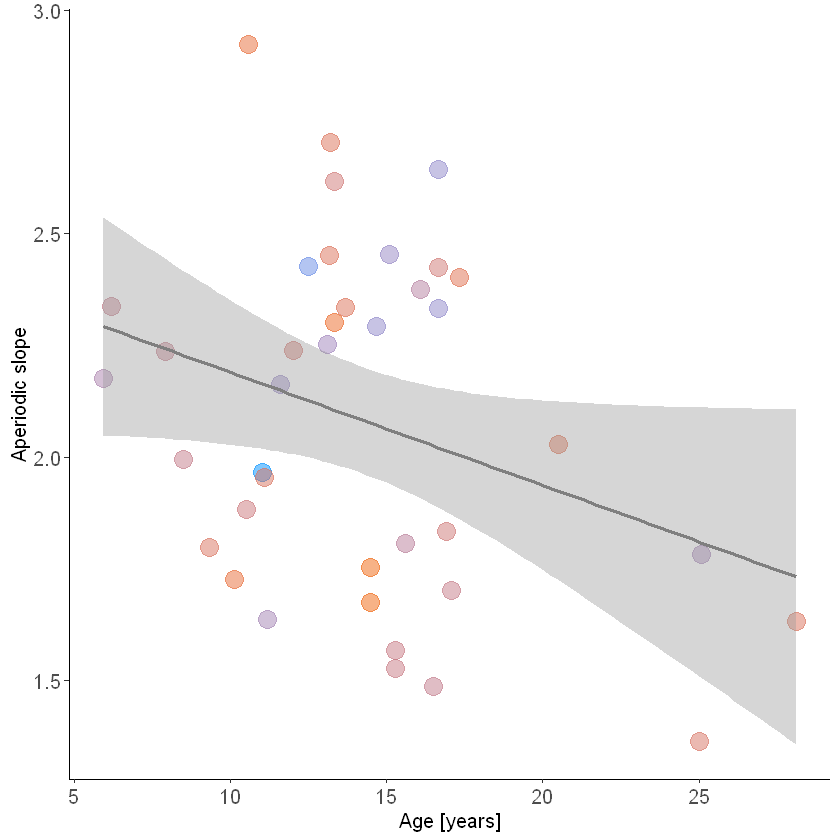

In [479]:
ggplot(filter(na.omit(plot_data_pcc), DKT == 'postcentral'), aes(x = age, y = Slope, color = gmv)) + 
    geom_point(alpha = .5, size = 5) +
    geom_smooth(method = 'lm', linetype = 'solid', colour = 'gray50') +
    scale_color_gradient(low = '#0091ff', high = '#f0650e', name = 'GMV [mm3]') +
    labs(x='Age [years]', y = 'Aperiodic slope') +
    theme_classic()  +
    theme(legend.position='none',
        legend.spacing.x = unit(0.1, 'cm'),
        legend.key.size = unit(0.5, 'cm'),
        legend.background = element_rect(fill=alpha('blue', 0)),
        legend.text = element_text(size = 10, colour = 'black'),
        legend.title = element_text(size = 12, colour = 'black'),
        strip.text.x = element_text(size = 12, colour = 'black'),
        strip.text.y = element_text(size = 12, colour = 'black'),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        plot.title = element_text(size = 10, face = 'bold'))